# Manipulations sur le pré-traitement des données EEG

L'objectif de ce cahier est d'expérimenter sur le pré-traitement effectué sur les données EEG fournies.

Nous importons tout d'abord le module MNE pour manipuler les données.
Nous importons également le module matplotlib.pyplot pour les affichages.

In [1]:
import mne
import matplotlib.pyplot as plt

Nous lisons ensuite les données brutes et celles pré-traitées (ici S10_NF1).

In [2]:
raw = mne.io.read_raw_brainvision('../EEG_Data/raw/S10_NF1.vhdr')
pp = mne.io.read_raw_brainvision('../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr')

Extracting parameters from ../EEG_Data/raw/S10_NF1.vhdr...
Setting channel info structure...
Extracting parameters from ../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr...
Setting channel info structure...
DigMontage is a superset of info. 1 in DigMontage will be ignored. The ignored channels are: {'ECG'}


<ipython-input-2-f44402bd3d6d>:2: RuntimeWarning: No coordinate information found for channels ['ECG']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  pp = mne.io.read_raw_brainvision('../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr')
<ipython-input-2-f44402bd3d6d>:2: DeprecationWarning: The `montage` parameter from `read_raw_brainvision` is deprecated and will be removed  in version 0.20. Use  raw.set_montage(montage) instead.
  pp = mne.io.read_raw_brainvision('../EEG_Data/pp1/S10_NF1_$pp1_new.vhdr')


Les avertissements ci-dessus ne sont pas inquiétants. 

Nous affichons cependant les informations afin de s'assurer que tout est normal.

In [3]:
print(raw.info)
print(pp.info)

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.015915494309189534 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : tuple | 2016-08-03 09:54:04 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 5000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj

On note tout d'abord une forte diminution de la fréquence d'échantillonage, ce qui permet d'effacer une partie du bruit. On note également l'ajout d'un champ 'dig' dans les données pré-traitées.

On en extrait les données, que l'on affiche pour s'assurer que tout fonctionne bien.

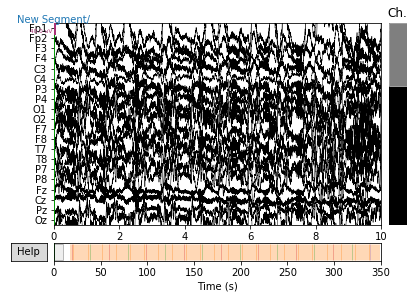

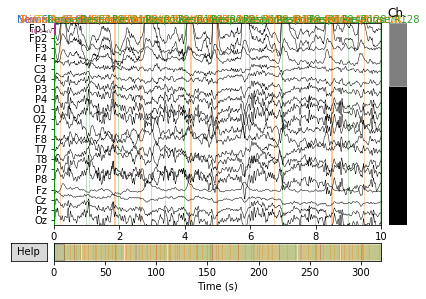

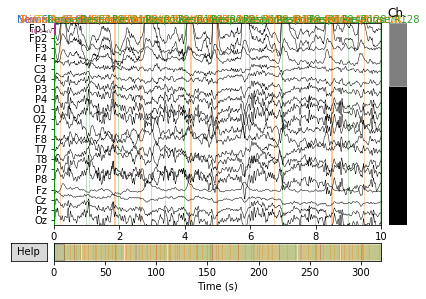

In [4]:
#time_interval = [20,50]
#raw_start_time, raw_stop_time = raw.time_as_index(time_interval)
#pp_start_time, pp_stop_time = pp.time_as_index(time_interval)

raw_data, raw_time = raw[:, :]
pp_data, pp_time = pp[:, :]

raw.plot()
pp.plot()

Nous nous intéresserons par la suite à la première électrode, étiquetée "Ep1".

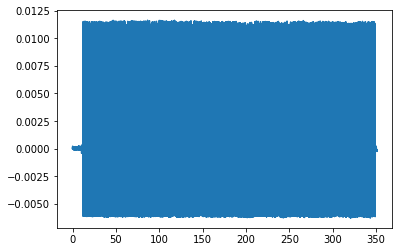

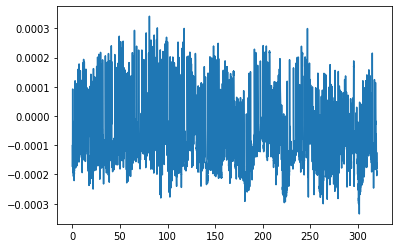

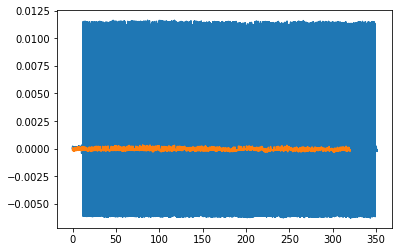

In [5]:
ep1_raw_data = raw_data[1,:]
ep1_pp_data = pp_data[1,:]

plt.plot(raw_time,ep1_raw_data)
plt.show()
plt.plot(pp_time, ep1_pp_data)
plt.show()

plt.plot(raw_time,ep1_raw_data)
plt.plot(pp_time, ep1_pp_data)
plt.show()

## Passage des données brutes aux pré-traitées

Nous allons ici retracer les étapes du pré-traitement tel que décrit dans le fichier "readme.rtf".

### Correction automatique de gradient

La première étape est de corriger l'artéfact de gradient, lié aux légères variations dans les gradients du champ magnétique de l'IRM, à une désynchronisation de l'EEG et de l'IRM, et à de léger mouvements de la tête.

Cela se fait à l'aide des marqueurs 'Response' du fichier .vmrk.

In [6]:
annotations = mne.read_annotations('../EEG_Data/raw/S10_NF1.vmrk')
response_annotations = [annotation for annotation in annotations if annotation['description'] == "Response/R128"]
print(len(response_annotations))

Finding 'sfreq' from header file: ../EEG_Data/raw/S10_NF1.vhdr
332


Ces marqueurs sont tous situés sur une trame unique (0.2 ms à 5kHz).

In [7]:
artifact_duration = response_annotations[0]['duration']
print(artifact_duration)

0.0002


In [8]:
for annotation in response_annotations:
    assert(annotation['duration'] == artifact_duration)

Vérifions si la position de ces marqueurs est périodique.

In [9]:
marker_period = response_annotations[1]['onset'] - response_annotations[0]['onset']

for i in range(len(response_annotations) - 1):
    if(response_annotations[i+1]['onset']-response_annotations[i]['onset'] != marker_period):
        print(response_annotations[i+1]['onset']-response_annotations[i]['onset'] - marker_period)

7.105427357601002e-15


Avec une fréquence d'échantillonnage à 5000 Hz, cette variation est négligeable (moins d'une trame). Nous allons donc considérer l'artéfact de gradient typique comme un "signal moyen" de ceux pris entre deux marqueurs.

Cela revient à faire l'hypothèse que le signal d'intérêt est de moyenne nulle (ou négligeable).

Nous allons dans un premier temps simplement retrancher au signal la moyenne glissante sur 21 intervalles de marqueurs. Nous allons utiliser la méthode cumsum du module np (https://stackoverflow.com/questions/13728392/moving-average-or-running-mean). 

In [10]:
import numpy as np

def cumsum_sma(array, period):
    ret = np.cumsum(array, dtype=float)
    ret[period:] = ret[period:] - ret[:-period]
    return ret[period - 1:] / period

def cumulative_interval_average(array, window_size, interval_size):
    averaged_array = []
    for i in range(window_size, len(array)):
        averaged_array.append(np.mean(array[i-window_size:i+1:interval_size]))
    return np.array(averaged_array)

sma_window_time_size = 21*marker_period
sma_window_frame_size = raw.time_as_index([0, sma_window_time_size])[1]
interval_size = raw.time_as_index([0, marker_period])[1]

print(interval_size)

#ep1_raw_averaged_raw_data = cumsum_sma(ep1_raw_data, sma_window_frame_size)
ep1_raw_averaged_raw_data = cumulative_interval_average(ep1_raw_data, sma_window_frame_size, interval_size)

5000


Nous complétons les bords par des 0 pour retrouver une taille normale.

In [11]:
print(ep1_raw_averaged_raw_data.shape)
print(ep1_raw_data.shape)

#size_diff = len(ep1_raw_data) - len(ep1_raw_averaged_raw_data)
v1_time = raw_time[sma_window_frame_size:]
#ep1_averaged_raw_data = np.concatenate([[0]*(size_diff//2), [0], ep1_raw_averaged_raw_data, [0]*(size_diff//2)])
ep1_averaged_raw_data = ep1_raw_averaged_raw_data

assert(ep1_averaged_raw_data.shape == v1_time.shape)


(1649500,)
(1754500,)


Nous faisons enfin la soustraction point par point.

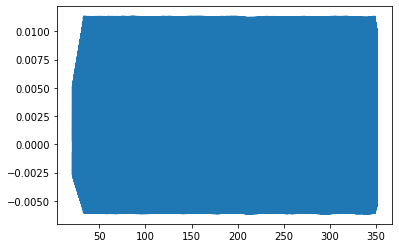

In [12]:
ep1_v1_pp_data = ep1_raw_data[sma_window_frame_size:] - ep1_averaged_raw_data

#plt.plot(raw_time, ep1_v1_pp_data)
plt.plot(v1_time, ep1_averaged_raw_data)
plt.show()

[221.     221.0002 221.0004 ... 240.9994 240.9996 240.9998]


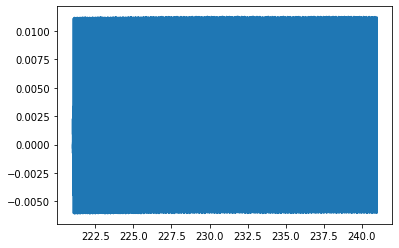

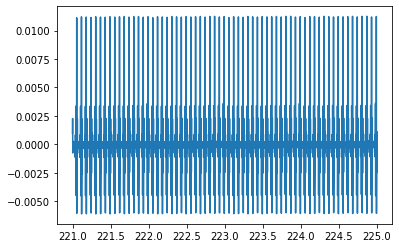

In [13]:
print(v1_time[1000000:1100000])
plt.plot(v1_time[1000000:1100000], ep1_averaged_raw_data[1000000:1100000])
plt.show()
plt.plot(v1_time[1000000:1020000], ep1_averaged_raw_data[1000000:1020000])#2sec

Nous créons donc une fonction de soustraction de cet artefact, pour réutilisation.

In [14]:
def get_gradient_artifact_marker_period(annotations):
    response_annotations = [annotation for annotation in annotations if annotation['description'] == "Response/R128"]
    
    #Safety check
    artifact_duration = response_annotations[0]['duration']
    for annotation in response_annotations:
        assert(annotation['duration'] == artifact_duration)
    
    marker_period = response_annotations[1]['onset'] - response_annotations[0]['onset']
    return marker_period

def clean_gradient(signal, time, averaging_size, marker_period):
    """
    Cleans a signal from the gradient artifact.
    ---
    Inputs:
        - signal: 1D float array. The signal as a numerical array.
        - time: 1D float array. The time corresponding to the input signal.
        - averaging_size: int. The number of intervals on which the gradient template is averaged.
        - marker_period: float. The duration (in seconds) between two marker gradients. Periodicity is required.
    ---
    Outputs:
        - cleaned_signal: 1D float array. The signal cleaned from gradient artifact.
        - cleaned_time : 1D float array. The time corresponding to the cleaned signal. 
                Basically the input time from the moment when there is enough data to average.
    """
    sma_window_time_size = averaging_size*marker_period
    sma_window_frame_size = raw.time_as_index([0, sma_window_time_size])[1]
    interval_size = raw.time_as_index([0, marker_period])[1]
    
    averaged_signal = cumulative_interval_average(signal, sma_window_frame_size, interval_size)
    
    cleaned_signal = signal[sma_window_frame_size:] - averaged_signal
    cleaned_time = raw_time[sma_window_frame_size:]
    
    return cleaned_signal, cleaned_time    
    

### Sous-échantillonnage

Nous pouvons ensuite faire un sous-échantillonnage du signal, à 200 Hz, à l'aide de la méthode resample du module scipy.signal.

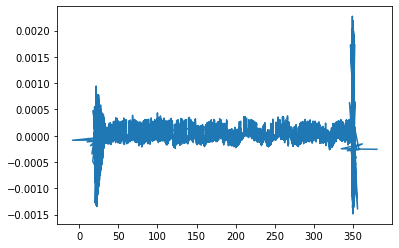

In [15]:
from scipy import signal

samples_amount = len(ep1_v1_pp_data)//25
ep1_v2_pp_data = signal.resample(ep1_v1_pp_data, samples_amount)
resampled_time = signal.resample(v1_time, samples_amount)

plt.plot(resampled_time, ep1_v2_pp_data)
plt.show()

Nous définissons à nouveau la fonction associée:

In [16]:
def undersample(full_signal, time, diminution_factor=25):
    """
    Undersamples a signal.
    ---
    Inputs:
        - full_signal: 1D float array. The numerical values of the signal to undersample.
        - time: 1D float_array. The time association to the undersampled signal.
        - diminution_factor: int. The factor between the amounts of samples after and before treatment.
    ---
    Outputs:
        - undersampled_signal: 1D float array. The numerical values of the undersampled signal.
        - undersampled_time: 1D float_array. The time association to the undersampled signal.
    """
    samples_amount = len(full_signal)//25
    undersampled_signal = signal.resample(full_signal, samples_amount)
    undersampled_time = signal.resample(time, samples_amount)
    
    return undersampled_signal,undersampled_time

### Filtre passe-bas

Nous appliquons ensuite un filtre passe-bas à réponse impulsionnelle finie de 50 Hz, les fréquences supérieures étant considérées comme du bruit.

In [17]:
sample_rate = 200

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = signal.kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 50

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter to filter x with the FIR filter.
ep1_v3_pp_data = signal.lfilter(taps, 1.0, ep1_v2_pp_data)

Nous affichons ensuite le signal obtenu, ici en orange, comparé au signal précédent, en bleu.

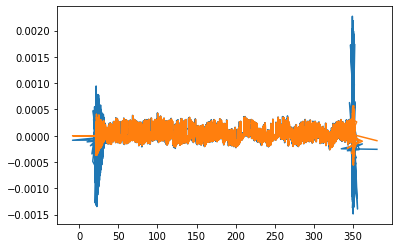

In [18]:
plt.plot(resampled_time, ep1_v2_pp_data)
plt.plot(resampled_time, ep1_v3_pp_data)
plt.show()

Nous définissons encore une fois la fonction associée.

In [19]:
def low_pass_filter(full_signal, sample_rate=200, transition_width=5, ripple_db=60.0,cutoff_hz=50):
    """
    TODO: DOC
    """
    nyq_rate = sample_rate / 2.0
    width = 5.0/nyq_rate
    N, beta = signal.kaiserord(ripple_db, width)
    taps = signal.firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
    low_passed_signal = signal.lfilter(taps, 1.0, full_signal)
    
    return low_passed_signal

## Correction de l'artefact de pouls

Nous nous attachons d'abord à récupérer l'électro-cardiogramme à travers l'électrode "ECG".

In [20]:
print(raw.info)
print(raw.ch_names)
ecg_channel_index = raw.ch_names.index('ECG')
print(ecg_channel_index)

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, ...
    chs : list | 64 items (EEG: 64)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.015915494309189534 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : tuple | 2016-08-03 09:54:04 GMT
    nchan : int | 64
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 5000.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj

[0.000000e+00 2.000000e-04 4.000000e-04 ... 3.508994e+02 3.508996e+02
 3.508998e+02]


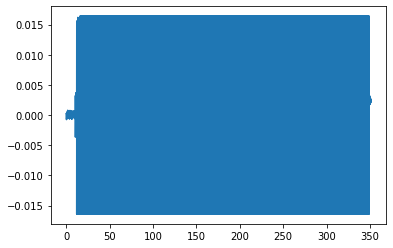

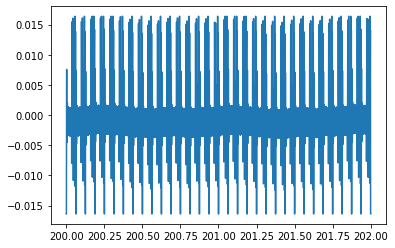

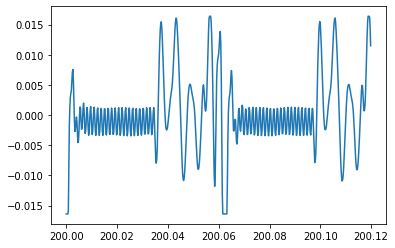

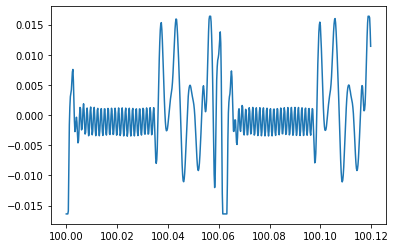

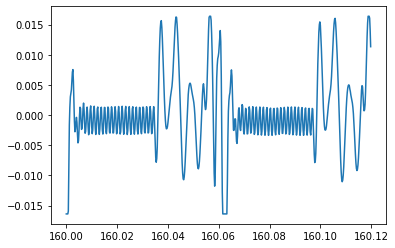

In [21]:
ecg_data = raw_data[ecg_channel_index,:]

print(raw_time)

plt.plot(raw_time, ecg_data )
plt.show()
plt.plot(raw_time[1000000:1010000], ecg_data[1000000:1010000])
plt.show()
plt.plot(raw_time[1000000:1000600], ecg_data[1000000:1000600])
plt.show()
i = 500000
plt.plot(raw_time[i:i+600], ecg_data[i:i+600])
plt.show()
i = 800000
plt.plot(raw_time[i:i+600], ecg_data[i:i+600])
plt.show()

**NB : Cela n'a pas vraiment la tête d'un AP (complexe QRS). Cela est sans doute du à la présence de l'artefact de gradient.**

Nous commençons donc par retirer l'artefact de gradient.

Soustraction de l'artéfact de gradient


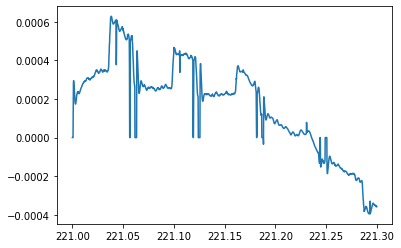

In [22]:
marker_period = get_gradient_artifact_marker_period(annotations)

cleaned_ecg_data,cleaned_time = clean_gradient(ecg_data, raw_time, 21, marker_period)


s=1000000
size = 1500
print("Soustraction de l'artéfact de gradient")
plt.plot(cleaned_time[s:s+size], cleaned_ecg_data[s:s+size])
plt.show()

Nous appliquons ensuite le sous-échantillonnage et le filtre passe-bas.

Signal ECG : 


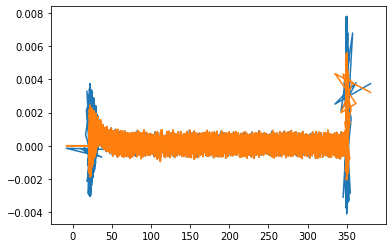

Zoom :


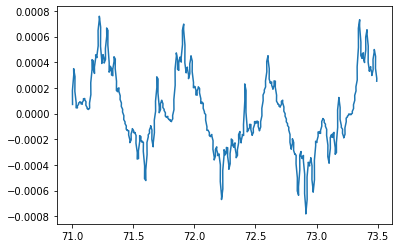

In [23]:
undersampled_ecg_data, undersampled_time = undersample(cleaned_ecg_data, cleaned_time,25)
low_passed_ecg_data = low_pass_filter(undersampled_ecg_data)
print("Signal ECG : ")
plt.plot(undersampled_time,undersampled_ecg_data)
plt.plot(undersampled_time,low_passed_ecg_data)
plt.show()

print("Zoom :")
start = 10000
size = 500
plt.plot(undersampled_time[start:start+size],low_passed_ecg_data[start:start+size])
plt.show()


L'objectif est alors d'y identifier les pics afin de récupérer les marqueurs de l'artefact de pouls. 

Nous pourrons ensuite obtenir sa forme en employant ces marqueurs sur le canal EEG de référence.

### Filtre passe-bas en moyenne glissante

Afin de réduire le bruit en haute fréquence, nous appliquons un filtre passe-bas en moyenne glissante sur 3 coefficients.

Signal filtré :


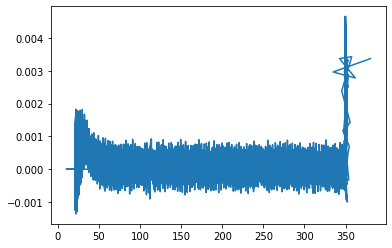

Zoom :


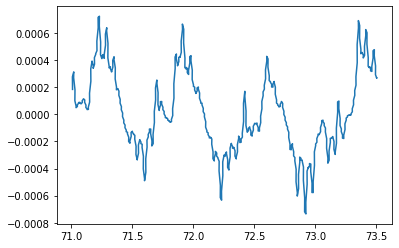

In [35]:
ecg_pulse_artifact = low_passed_ecg_data

low_passed_ecg_pulse_artifact = cumsum_sma(ecg_pulse_artifact, period = 3)
low_passed_ecg_time = undersampled_time[2:]

print("Signal filtré :")
plt.plot(low_passed_ecg_time, low_passed_ecg_pulse_artifact)
plt.show()
print("Zoom :")
start = 10000
size = 500
plt.plot(low_passed_ecg_time[start:start+size], low_passed_ecg_pulse_artifact[start:start+size])
plt.show()

### Filtre passe-haut à réponse impulsionnelle finie

Nous appliquons ensuite un filtre passe-haut afin de réduire l'effet des changements de référentiel de l'IRM. Ce filtre est à réponse impulsionnelle finie (sur 25 coefficients), avec une coupure à 20 Hz.

Nous employons à cette fin les fonctions **firwin**, du module *scipy.signal*, et **convolve**, du module *numpy*,, selon les scripts du [livre de recettes SciPy](https://scipy-cookbook.readthedocs.io/items/ApplyFIRFilter.html). 

Signal filtré :


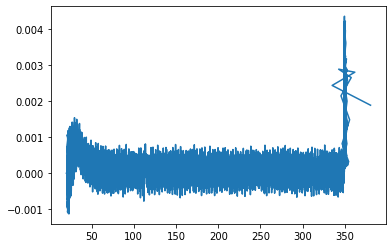

Zoom :


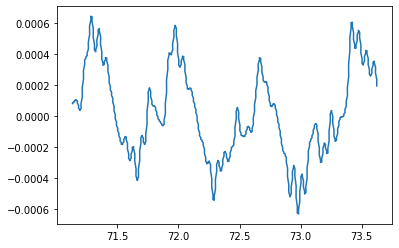

In [37]:
FIR_filter = signal.firwin(numtaps = 25, cutoff = 20, nyq = 200/2.)

high_passed_ecg_pulse_artifact = np.convolve(low_passed_ecg_pulse_artifact, FIR_filter, mode='valid')
high_passed_ecg_time = low_passed_ecg_time[24:]

print("Signal filtré :")
plt.plot(high_passed_ecg_time, high_passed_ecg_pulse_artifact)
plt.show()
print("Zoom :")
start = 10000
size = 500
plt.plot(high_passed_ecg_time[start:start+size], high_passed_ecg_pulse_artifact[start:start+size])
plt.show()

16295


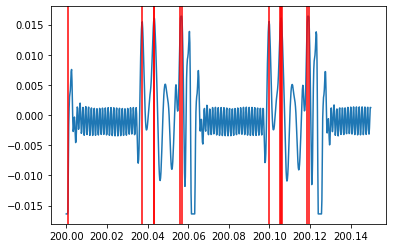

In [25]:
start_time = 20 #s
end_time = 240 #s
sfreq = 5000 #Hz #raw.sfreq not working
start_index = start_time * sfreq
end_index = end_time * sfreq

threshold = 0.015
peaks_indices = []

for i in range(start_index, end_index+1):
    above_threshold = abs(ecg_data[i]) > threshold
    curve_inversion = (ecg_data[i-1]-ecg_data[i])*(ecg_data[i]-ecg_data[i+1]) > 0
    if above_threshold and curve_inversion:
        peaks_indices.append(i)
        
print(len(peaks_indices))

s=1000000
size = 750
plt.plot(raw_time[s:s+size], ecg_data[s:s+size])
local_peaks_indices = [i for i in peaks_indices if (s<i and i<s+size)]
for i in local_peaks_indices:
    plt.axvline(raw_time[i], color ='red')
plt.show()

Les pics ne délimitent pas bien les artefacts; il y en a plusieur par pulsation.

Nous allons donc nettoyer ce tableau en éliminant les pics trop proches.

Par simplicité, nous allons regrouper les pics suffisamment proches, et conserver seulement le plus intense.

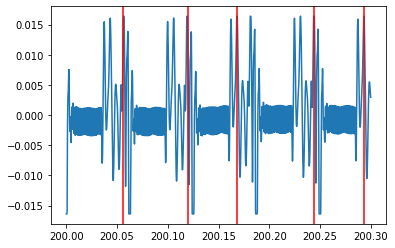

In [26]:
min_period = 0.02 #s
peaks_indices_group = [[peaks_indices[0]]]
for i in peaks_indices[1:]:
    last_index = peaks_indices_group[-1][-1]
    time_distance = raw_time[i] - raw_time[last_index]
    if time_distance < min_period:
        peaks_indices_group[-1].append(i)
    else:
        peaks_indices_group.append([i])

cleaned_peaks_indices = []
for indices_group in peaks_indices_group:
    max_index = indices_group[0]
    max_amplitude = ecg_data[max_index]
    for i in range(1, len(indices_group)):
        amplitude = ecg_data[indices_group[i]]
        if amplitude > max_amplitude:
            max_index = indices_group[i]
            max_amplitude = amplitude
    cleaned_peaks_indices.append(max_index)
    
s=1000000
size = 1500
plt.plot(raw_time[s:s+size], ecg_data[s:s+size])
local_cleaned_peaks_indices = [i for i in cleaned_peaks_indices if (s<i and i<s+size)]
for i in local_cleaned_peaks_indices:
    plt.axvline(raw_time[i], color ='red')
plt.show()

# ANCIENS ESSAIS

Cela vérifié, nous pouvons moyenner point par point.

**NOTA BENE : à refaire avec une moyenne glissante**

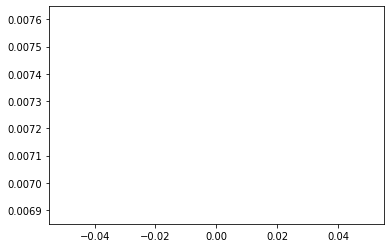

(1,) (1754500,)
(1,)


In [27]:
artifacts_signals = np.array([ep1_raw_data[
                                            raw.time_as_index([annotation['onset'], 
                                                               annotation['onset']+annotation['duration']])[0]:
                                            raw.time_as_index([annotation['onset'], 
                                                               annotation['onset']+annotation['duration']])[1]
    
                                          ] 
                              for annotation in response_annotations])

mean_artifact_signal = np.mean(artifacts_signals, axis = 0)
time_reference = np.arange(0, len(mean_artifact_signal))/len(mean_artifact_signal)*artifact_duration

plt.plot(time_reference, mean_artifact_signal)
plt.show()

print(mean_artifact_signal.shape,ep1_raw_data.shape)
print(artifacts_signals[0].shape)

Nous pouvons ensuite soustraire cette forme au signal original au niveau des artéfacts.

In [28]:
for annotation in response_annotations:
    artifact_time_interval = ([annotation['onset'], 
                               annotation['onset']+annotation['duration']])
    artifact_start_frame, artifact_end_frame = raw.time_as_index(artifact_time_interval)
    
    
    print(artifact_time_interval)
    print(artifact_start_frame, artifact_end_frame)
    print(ep1_raw_data[ artifact_start_frame : artifact_end_frame ])
    ep1_raw_data[ artifact_start_frame : artifact_end_frame ]-= mean_artifact_signal

[16.9916, 16.991799999999998]
84958 84959
[0.0072555]
[17.9916, 17.991799999999998]
89958 89959
[0.007235]
[18.9916, 18.991799999999998]
94958 94959
[0.007259]
[19.9916, 19.991799999999998]
99958 99959
[0.007216]
[20.9916, 20.991799999999998]
104958 104959
[0.007223]
[21.9916, 21.991799999999998]
109958 109959
[0.0073525]
[22.9916, 22.991799999999998]
114958 114959
[0.0071555]
[23.9916, 23.991799999999998]
119958 119959
[0.007345]
[24.9916, 24.991799999999998]
124958 124959
[0.0073145]
[25.9916, 25.991799999999998]
129958 129959
[0.00743]
[26.9916, 26.991799999999998]
134958 134959
[0.007236]
[27.9916, 27.991799999999998]
139958 139959
[0.0072175]
[28.9916, 28.991799999999998]
144958 144959
[0.007219]
[29.9916, 29.991799999999998]
149958 149959
[0.007394]
[30.9916, 30.991799999999998]
154958 154959
[0.0073415]
[31.9916, 31.991799999999998]
159958 159959
[0.0072315]
[32.9916, 32.9918]
164958 164959
[0.007358]
[33.9916, 33.9918]
169958 169959
[0.007273]
[34.9916, 34.9918]
174958 174959
[